### Notebook reference
- [IBM Quantum Learning Course - Variational algorithm design](https://learning.quantum.ibm.com/course/variational-algorithm-design)
- [IBM Quantum Challenge Fall 2022 - Lab3](https://github.com/qiskit-community/ibm-quantum-challenge-fall-22/blob/main/content/lab-3/lab3.ipynb)
- [IBM Quantum Challenge Fall 2022 - Lab3-ko](https://github.com/qiskit-community/ibm-quantum-challenge-fall-22/blob/main/content/lab-3/lab3-ko.ipynb)

In [33]:
import warnings
warnings.filterwarnings(action='ignore')  # 실행 중 표시되는 경고를 무시합니다 (optional)

# 필요한 라이브러리들을 불러와봅시다
import qiskit
import qiskit_ibm_runtime
import qiskit_machine_learning
import qiskit_optimization

import qiskit.tools.jupyter
%qiskit_version_table  # import 된 qiskit 라이브러리들의 버전을 표시합니다

del qiskit, qiskit_ibm_runtime, qiskit_machine_learning, qiskit_optimization

## VQE 구현해보기

다음 순서에 따라 VQE 알고리즘을 구현해봅시다

1. 최적화하고자 하는 cost function을 SparsePauliOp를 이용해 정의합니다.

2. Cost function의 값을 최적화(최소화) 할 수 있는 ansatz(가설답안)을 설정합니다.

3. Qiskit primitive - Estimator를 이용해 cost function의 값을 계산하는 함수를 정의합니다.

4. 최적화를 수행합니다.

### 1. 최적화하고자 하는 cost function을 SparsePauliOp를 이용해 정의합니다.

아래와 같은 operator를 `SparsePauliOp` 클래스를 이용해 정의해보세요.

$O_1 = 2 II -2 XX +3 YY -3 ZZ$

In [ ]:
from qiskit.quantum_info import SparsePauliOp

observable_1 = SparsePauliOp.from_list([("II", 2), ])  # 함수를 완성해주세요
print(observable_1)

### 2. Cost function의 값을 최적화(최소화) 할 수 있는 ansatz(가설답안)을 설정합니다.

여기서는 초기 추정으로 `01` 상태를 준비했으며, 변수 추정을 수행할 부분은 `TwoLocal` 클래스를 이용해 구현했습니다. 입력값을 바꿔보며 원하는 ansatz를 구현해보세요.

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal

# Solution에 대한 추정이 가능하다면 reference circuit을 설정할 수 있습니다.
reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

# Solution 상태를 표현할 수 있도록 변수를 포함한 회로를 구현합니다.
variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

ansatz.decompose().draw('mpl')

### 3. Qiskit primitive - Estimator를 이용해 cost function의 값을 계산하는 함수를 정의합니다.

Operator와 ansatz가 주어지면 `Estimator` primitive를 이용해 cost function을 계산할 수 있습니다. 다음 코드를 보고 이 작업을 수행하는 방법을 숙지해주세요.

In [ ]:
from qiskit.primitives import Estimator

estimator = Estimator()  # Estimator를 불러옵니다.

In [ ]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]  # Estimator를 이용해 cost function을 계산합니다.
    return cost

### 4. 최적화를 수행합니다.

최적화 작업은 classical part에 해당합니다. 다음 코드를 보고 최적화를 수행하는 방법을 숙지해주세요.

In [ ]:
import numpy as np

x0 = np.ones(8)  # parameter의 초기값을 설정합니다.

In [ ]:
# SciPy 최소화 함수를 불러옵니다.
from scipy.optimize import minimize
import time

start_time = time.time()

result = minimize(cost_func_vqe, x0, args=(ansatz, observable_1, estimator), method="COBYLA")  # 최적화를 수행합니다.

end_time = time.time()
execution_time = end_time - start_time

print(result)

In [ ]:
from numpy.linalg import eigvalsh

experimental_min_eigenvalue = result.fun
solution_eigenvalue = min(eigvalsh(observable_1.to_matrix()))  # ideal solution을 구합니다.

# 계산 횟수와 시간, 오차 정보를 표시합니다.
print(f"""Number of iterations: {result.nfev}""")
print(f"""Time (s): {execution_time}""")
print(
    f"Percent error: {abs((experimental_min_eigenvalue - solution_eigenvalue)/solution_eigenvalue):.2e}"
)

## (Optional) qiskit_algorithms를 이용해 VQE 구현해보기

Qiskit ecosystem 프로젝트인 qiskit_algorithms 패키지에는 VQE 알고리즘을 구현한 클래스가 있습니다. Quantum Explorers에서는 qiskit_algorithms 패키지를 사용하는 방법을 기준으로 코딩 문제를 출제하였습니다.

3. Optional - qiskit_algorithms.VQE 클래스를 이용해 cost function의 값을 계산하고 최적화를 수행하는 프로세스를 한꺼번에 정의합니다.

### 3. Optional - qiskit_algorithms.VQE 클래스를 이용해 cost function의 값을 계산하고 최적화를 수행하는 프로세스를 한꺼번에 정의합니다.

In [ ]:
from qiskit_algorithms import VQE

def RunVQE(estimator, model, optimizer, operator, init=None):
    """Return result of VQE algorithm

    Parameters:
        estimator (Estimator): Estimator primitive instance
        model (QuantumCircuit): Parameterized ansatz circuit
        optimizer (Optimizer): Optimizer instance from qiskit_algorithms.optimizers
        operator (SparsePauliOp): Operator to be optimized
        init (ndarray): Array of initial parameters

    Returns:
        result (VQEResult): Comprehensive class for result of VQE algorithm and its metadata
        mean (List[float]): History of expectation values
    """
    # 중간 계산 결과를 저장하는 dictionary 입니다.
    history = {"eval_count": [], "parameters": [], "mean": [], "metadata": []}

    # callback 함수를 정의합니다.
    def store_intermediate_result(eval_count, parameters, mean, metadata):
        history["eval_count"].append(eval_count)
        history["parameters"].append(parameters)
        history["mean"].append(mean.real)

    # VQE 클래스를 설정합니다.
    vqe = VQE(estimator, model, optimizer, initial_point=init, callback=store_intermediate_result)

    # 주어진 operator의 최소 기댓값을 계산합니다.
    result = vqe.compute_minimum_eigenvalue(operator)

    return result, history["mean"]

In [ ]:
from qiskit_algorithms.optimizers import SPSA, SLSQP, L_BFGS_B

# 사용할 optimizer를 설정합니다. SLSQP, L_BFGS_B 등 다른 optimizer도 사용해보세요.
optimizer = SPSA(maxiter=50)

# RunVQE 함수를 실행합니다.
result, mean = RunVQE(estimator, ansatz, optimizer, observable_1, x0)

# 결과를 출력합니다.
print(result)

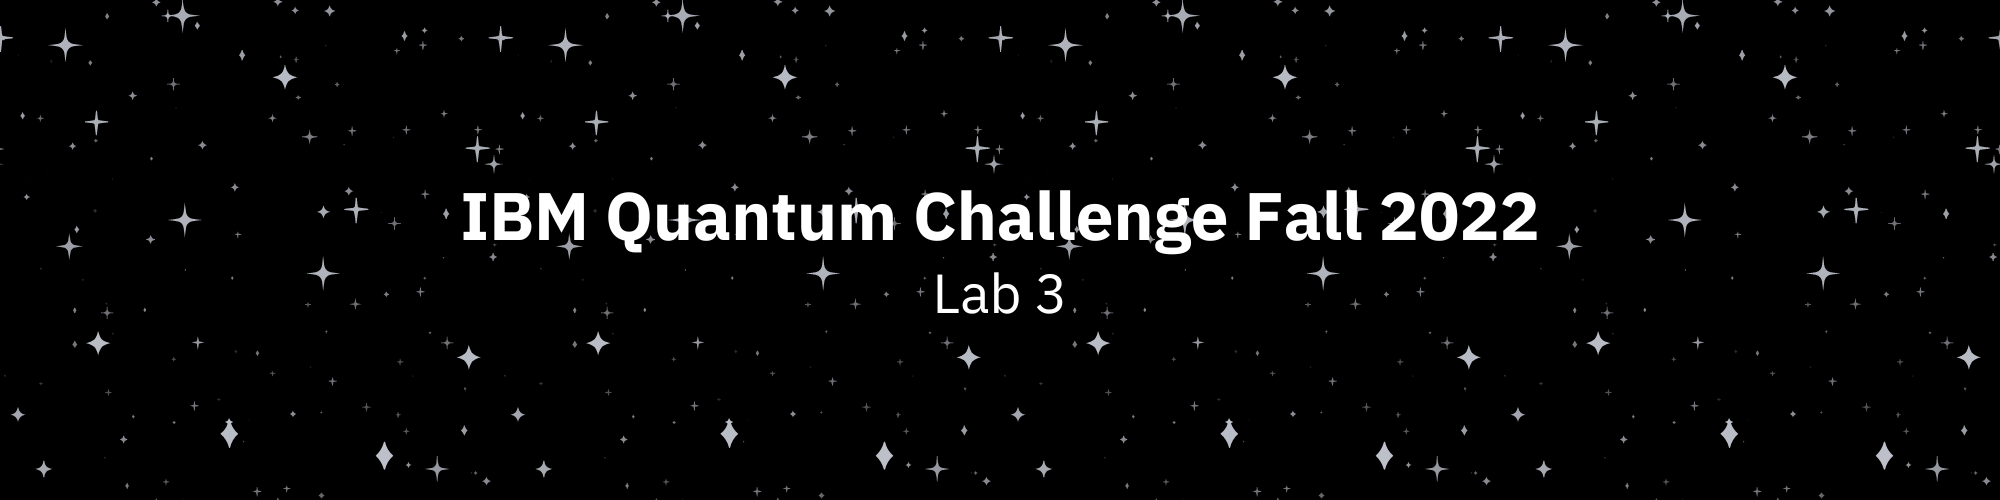

# Story - Chapter 3

양자컴퓨터와 스캐너도 수리되어 잘 동작하고 있기 때문에, 이제 당신은 중력 도움(Gravity assist)을 위한 최적의 행성을 찾아내는 일을 남겨두고 있습니다. 탈출을 위해서는 중력 슬링샷(Gravity Slingshot)이 잘 작동하는 것이 가장 중요합니다. 

최적화 프로토콜은 목성을 떠올리게 하는 큰 반점과 반짝이는 가스 소용돌이들이 있는 보라색 가스의 거대한 행성을 후보로 선택했습니다. 고장났던 시스템은 이 행성과는 완젼히 거리가 먼 다른 행성을 추천했었지요. 

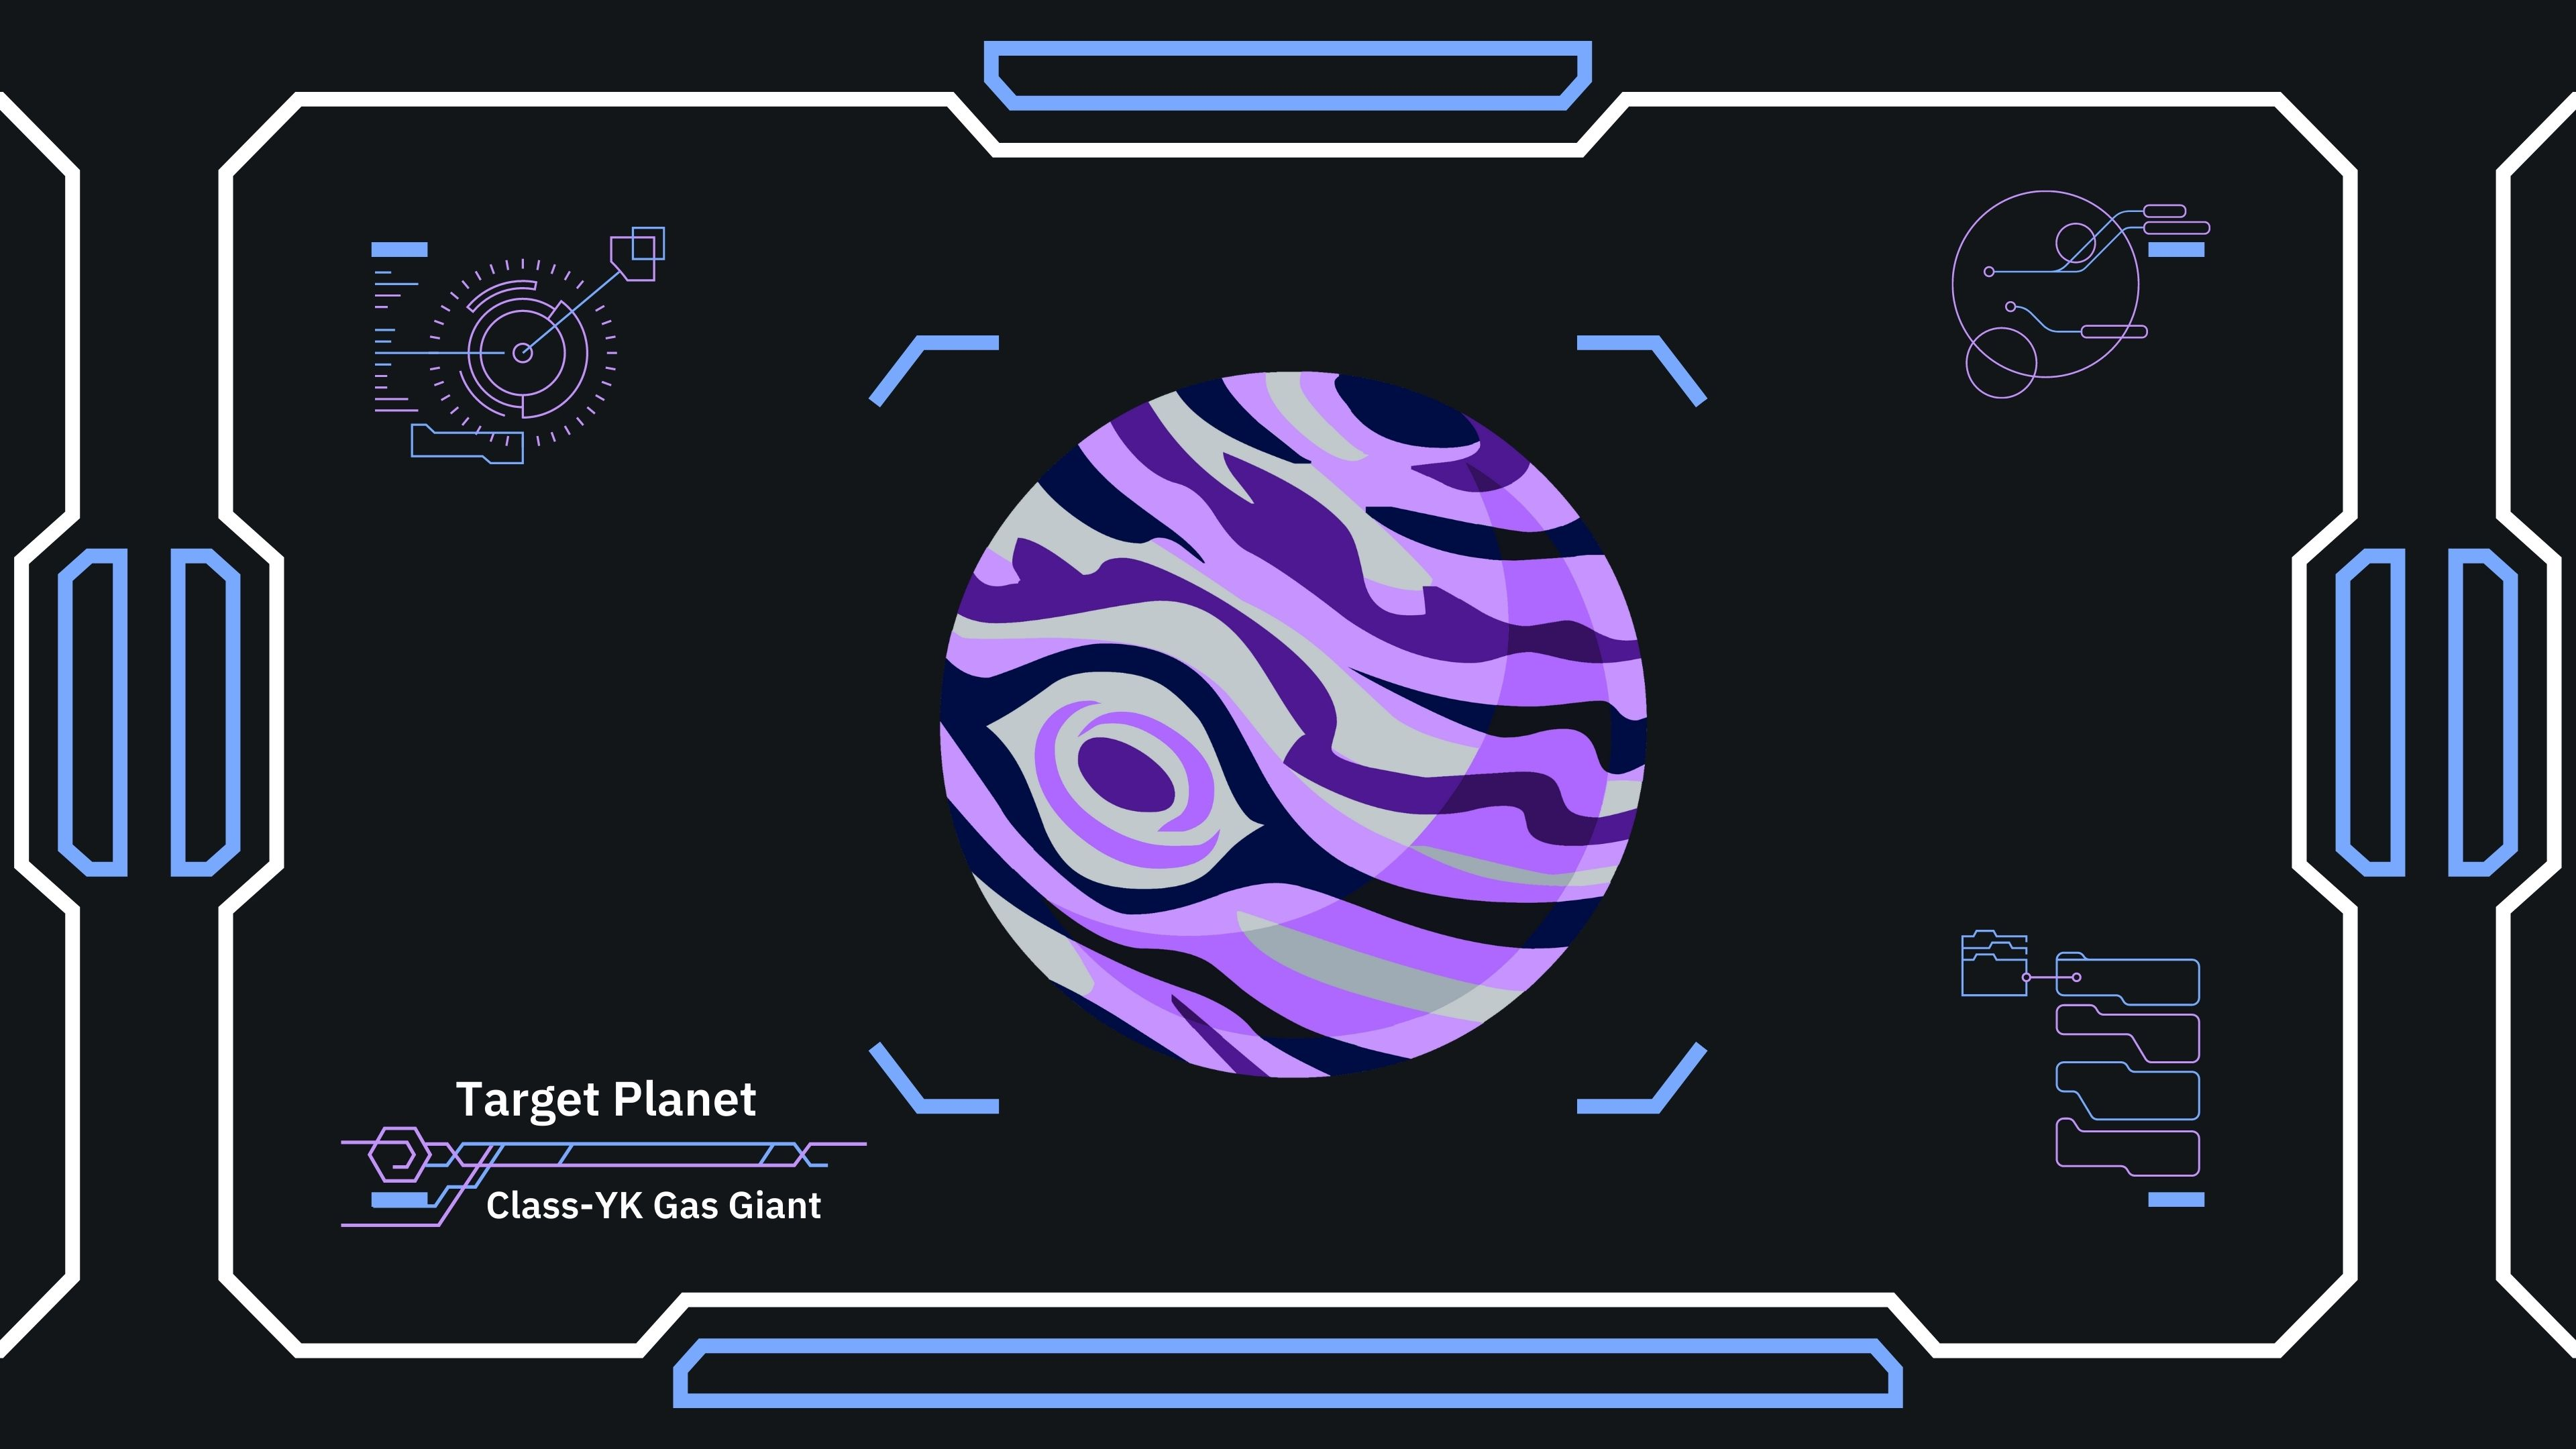

중력 슬링샷을 준비하던 중 당신은 아주 큰 장애물을 발견하게 되었습니다. 행성 주변에 우주 파편이 잔뜩 있습니다. 모래 처럼 작은 것부터 축구공처럼 큰 것, 금속 조각, 암석 조각, 소행성 충돌의 잔해, 그리고 오래전 사라진 문명의 흔적까지 무수히 많은 다양한 크기의 쓰레기가 행성의 주위 넓은 영역에 행성을 따라 회전하며 존재합니다.

중력 슬링샷은 위험에 처했습니다: 시속 2만 5천 킬로미터를 넘는 속도로 궤도를 돌고 있는 우주 쓰레기와의 충돌은 치명적입니다.  

하지만 희망을 잃지 마세요! 당신은 잘 작동하는 양자컴퓨터와 양자 최적화 프로토콜과 우주 쓰레기를 효율적으로 수집할 수 있는 드론을 우주선에 탑재하고 있습니다. 

아래의 연습문제들을 모두 완료하여 드론을 이용해 특정 궤도의 우주 쓰레기를 성공적으로 회수하여 우주선의 중력 슬링샷을 위한 최적 경로를 깨끗하게 청소하여 중력 슬링샷을 무사히 완수합시다.

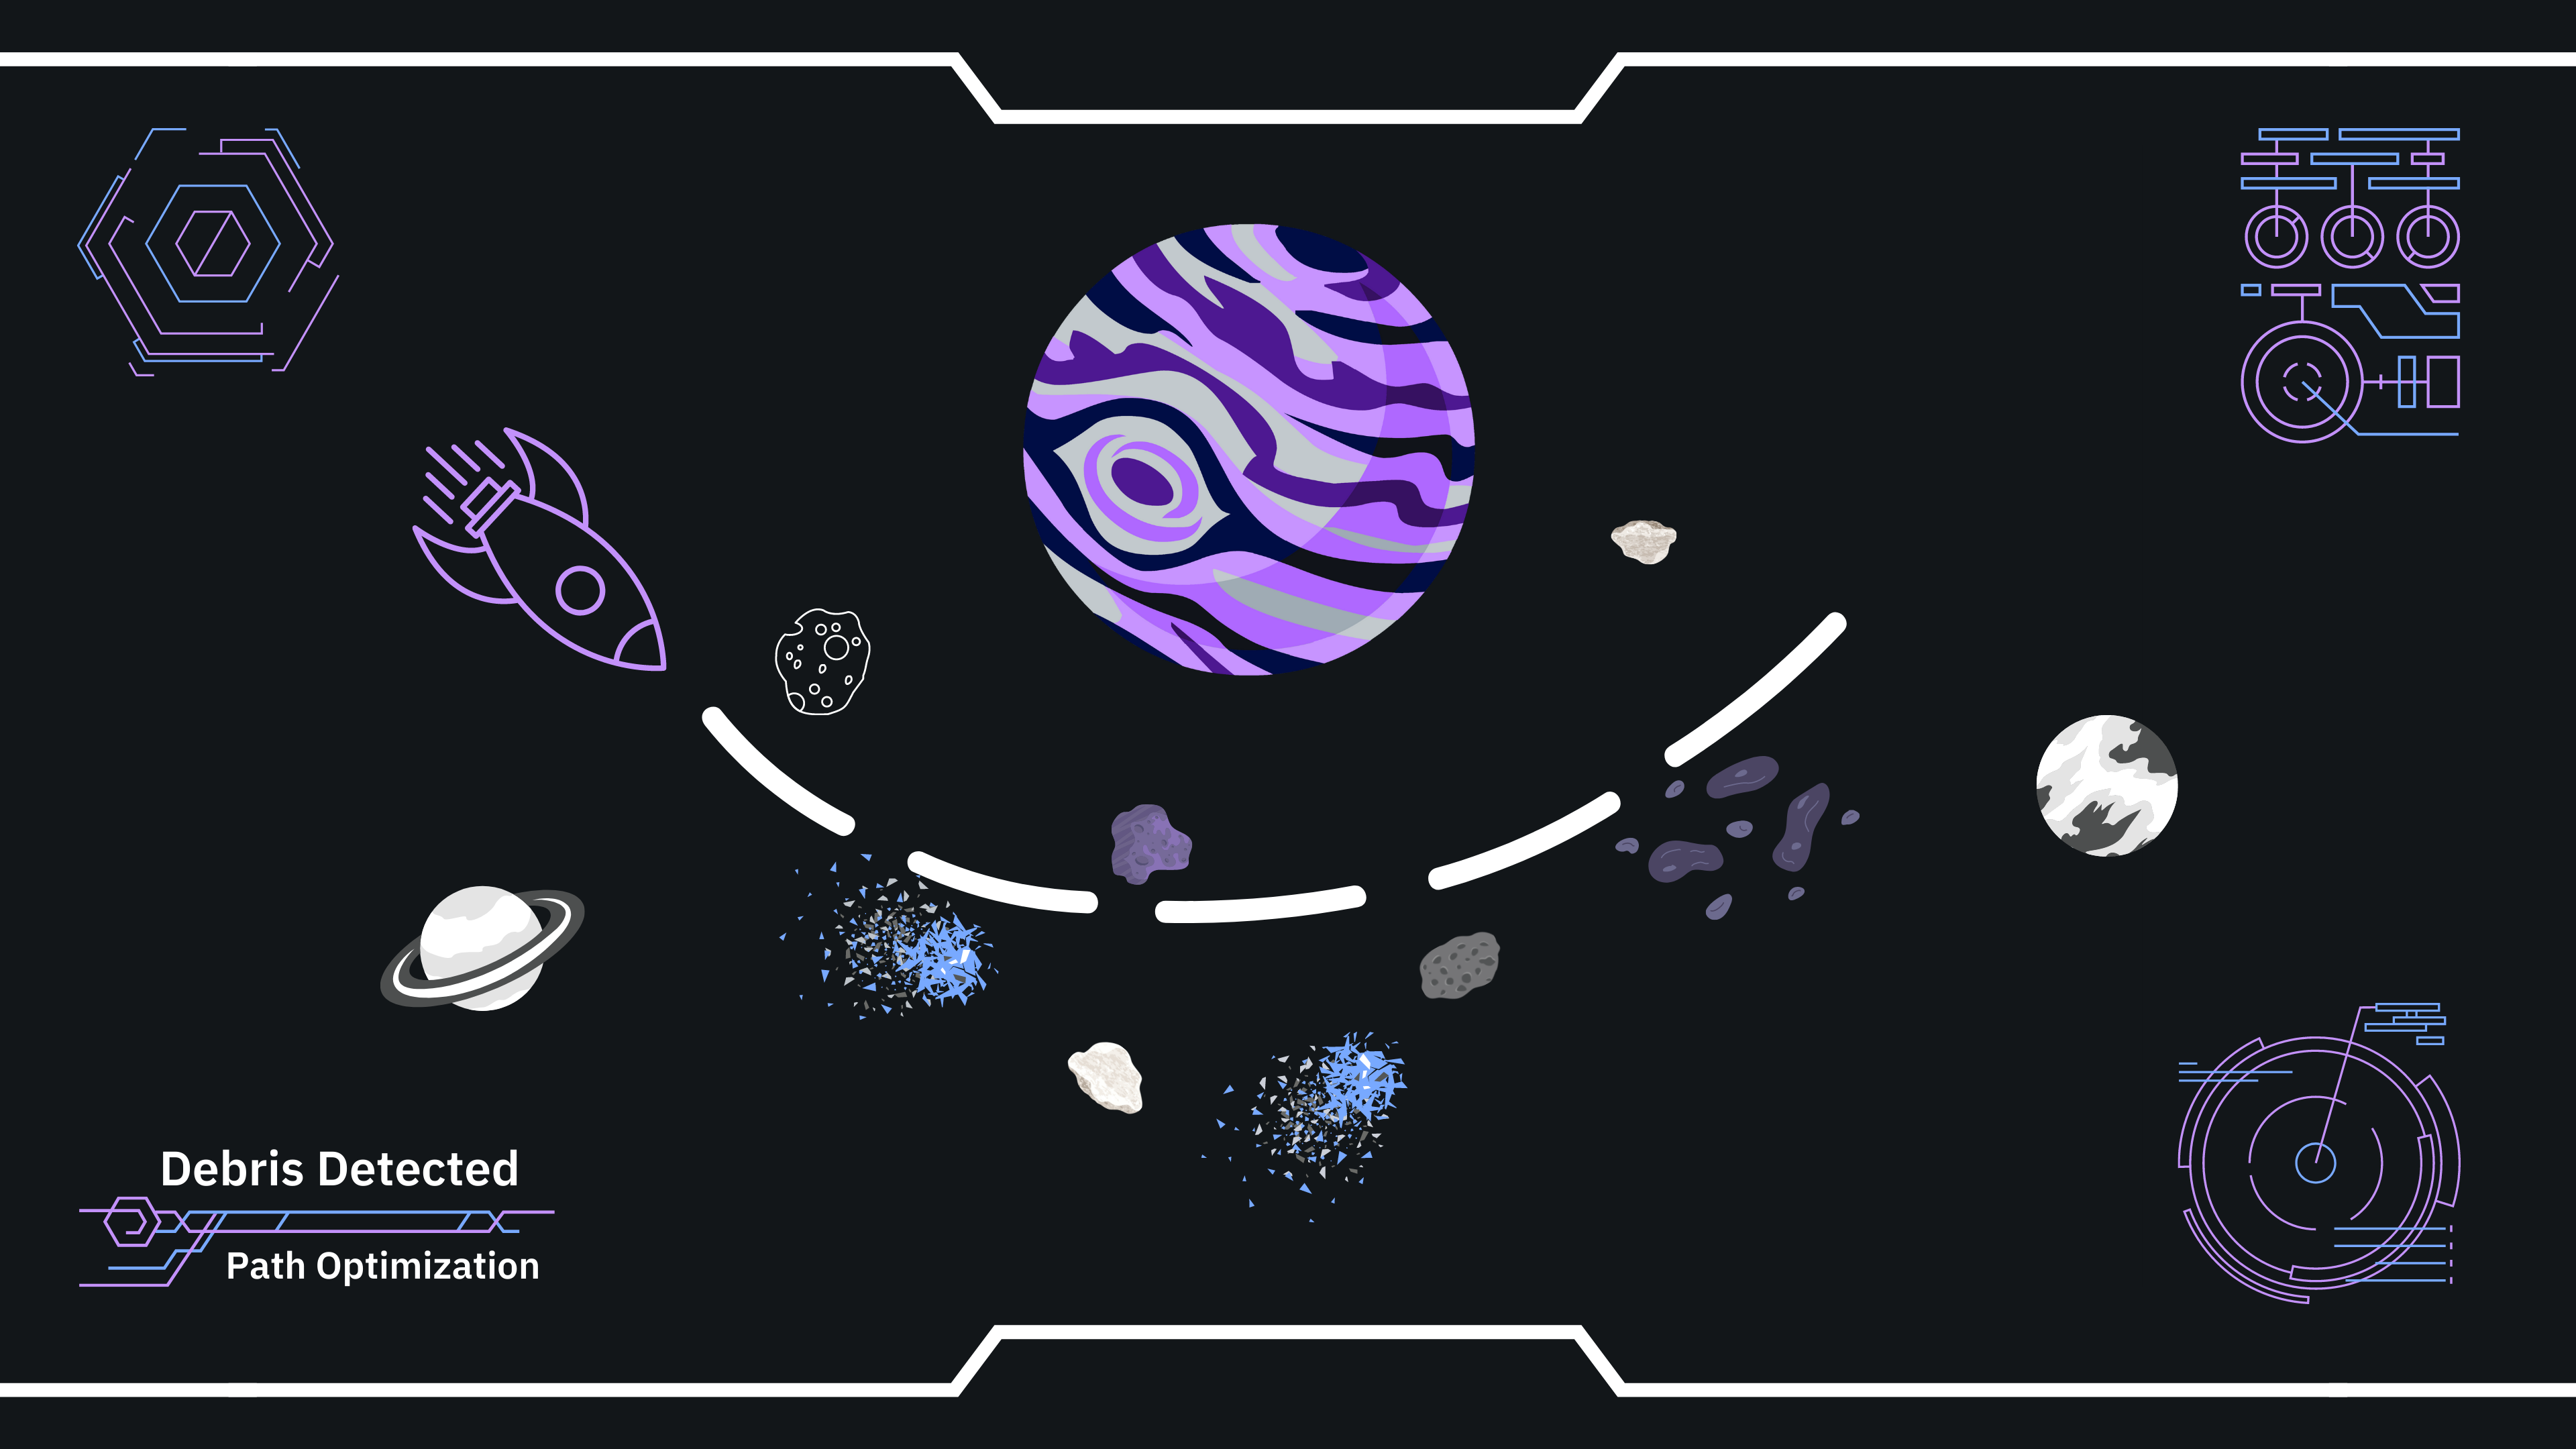

## Introduction to the Traveling Salesman Problem for Collecting Debris through the Shortest Path


당신의 경로 주변을 정리하기 위해 우주선과 충돌했을 때 치명적인 손상을 입힐 수 있을 만한 우주 쓰레기를 드론을 보내 정리합시다. 잘 동작하는 스캐너를 사용해 이 우주 쓰레기들 사이의 거리를 예측합니다. 블랙홀이 우리를 점점 더, 가까이 끌어당기고 있기 때문에 서둘러야 합니다. 가장 짧은 시간 내에 모든 쓰레기를 모으기 위한 드론의 최적의 경로(최단 경로)를 계산해야 합니다. 

우리가 마주한 잔해를 수집하기 위한 최단 경로를 찾아내는 문제는 잘 알려진 외판원 문제(Travelling salesman problem, TSP)와 본질적으로 같은 문제입니다. 이 TSP 문제는 이름에서 알 수 있듯 금융 및 마케팅 분야에서도 중요할 뿐 아니라 지난 2세기 이상 컴퓨터 과학자들과 수학자들의 관심을 끌어온 악명 높은 NP-완젼 (NP-Complete) 문제이기도 합니다. 쉽게 말해, 물건을 팔기 위해 도시들을 이동하는 외판원이 집에서 출발해 모든 도시를 거쳐 집으로 돌아오는 최단 경로를 찾고 그것이 최고의 매출로 이어지는 문제입니다. 

# Part I: Formulating the Traveling Salesman Problem

이 문제는 그 '어려움'과 실제로 존재하는 다른 조합 최적화 문제와의 등가성으로 인해 중요하게 다뤄집니다. 

이 문제의 수학적 공식화는 19세기 초에 W.R. Hamilton에 의해 제안되었으며 몇 가지 초기 작업이 이루어졌습니다. 최대 컷 문제 **[[1]](https://learn.qiskit.org/course/ch-applications/solving-combinatorial-optimization-problems-using-qaoa)** 의 경우와 마찬가지로 수학적으로 이 문제는 그래프의 관점에서 가장 잘 추상화됩니다. 그래프의 노드를 통해 표현된 TSP는 각각의 노드를 거치는 가장 짧은 *해밀턴 경로*를 묻습니다. 해밀턴 경로는 그래프의 모든 정점을 한 번씩 사용하는 닫힌 경로를 뜻합니다. 일반적인 해는 아직 알려지지 않았으며 효율적으로 (다항 시간 내) 해를 찾는 알고리즘은 아직 존재하지 않습니다.

노드 수 $n=|V|$ 와 거리 값 $w_{ij}$ (정점 $i$ 에서 정점 $j$ 까지의 거리) 이 설정된 그래프 $G=(V,E)$ 에서 가장 짧은 해밀턴 경로를 찾습니다. 해밀턴 경로는 $N^2$ 개의 변수와 $x_{i,p}$ 로 설명됩니다. 여기서 $i$ 는 노드를 나타내고, $p$ 는 다음 사이클에서의 순서를 나타냅니다. 만약 시간 순서 $p$ 에서 해가 노드 $i$ 에서 발견된다면 결정 변수는 값 1을 가집니다. 모든 노드가 경로에서 한 번만 선택되어야 하고, 시간의 단계마다 노드가 선택되어야 합니다. 두 제한 조건에 대한 양은 다음과 같습니다. (이하 따로 정의하지 않는 한, 0,1,...N-1 까지의 합)

<a id="eq1"></a>
$$
\begin{equation}\tag{1}
\sum_{i} x_{i,p} = 1 ~~\forall p.
\end{equation}
$$

<a id="eq2"></a>
$$
\begin{equation}\tag{2}
\sum_{p} x_{i,p} = 1 ~~\forall i.
\end{equation}
$$

$x_{i,p}$ 와 $x_{j,p+1}$ 가 둘 다 1일 때, 다음 순서에서 노드에 $(i,j) \notin E$ (그래프에 연결되지 않은 경우)의 에너지 패널티를 부과합니다. 이 패널티의 형태는 다음과 같습니다:

$$\sum_{i,j\notin E}\sum_{p} x_{i,p}x_{j,p+1}>0,$$ 

이 때, 해밀턴 경로 $(p=N)\equiv (p=0)$ 의 경계 조건을 가정합니다. 그러나 여기서는 완전히 연결된 그래프(fully connected graph)로 가정한 것으로 해당 항을 포함하지 않습니다. 최소화되어야 하는 거리는 다음과 같습니다: 

$$C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}.$$

모든 것을 최소화되어야 하는 하나의 목적함수에 넣으면 다음의 식을 얻습니다:

$$C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}+ A\sum_p\left(1- \sum_i x_{i,p}\right)^2+A\sum_i\left(1- \sum_p x_{i,p}\right)^2,$$

여기서 $A$ 는 자유 변수(free parameter)입니다. 이러한 제한 조건이 반영되기 위해서는 $A$ 가 충분히 커야 합니다. 이를 확실히 하기 위해서 $A$ 를 다음과 같은 조건을 두고 고릅니다: $A > \mathrm{max}(w_{ij})$.

양자 컴퓨터에 이러한 형태의 문제를 매핑하는 건 쉽습니다. 그리고 해는 Ising Hamiltonian을 최소화함으로써 찾을 수 있습니다. **[[2]](https://qiskit.org/documentation/optimization/tutorials/06_examples_max_cut_and_tsp.html)**

### Import necessary libraries and packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

### Create helper functions

In [ ]:
# 주어진 그래프 G를 그리는 함수입니다.
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=900, alpha=0.9, ax=default_axes, pos=pos, node_shape="o")
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

# 그래프 G로 주어진 TSP 문제에서 주어진 solution을 그리는 함수입니다.
def draw_tsp_solution(G, solution, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(solution)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(solution[i], solution[j], weight=G[solution[i]][solution[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

# 최적화 플랏을 그리는 함수입니다.
def PlotGraph(ideal, mean):
    plt.figure(figsize=(8, 6))
    # 기댓값의 최적화 그래프를 그립니다.
    for value in range(len(mean)):
        plt.plot(mean[value], label="Proposal {}".format(value+1) )
        
    # ideal 값을 표시합니다.
    plt.axhline(y=ideal, color="tab:red", ls="--", label="Target")
    plt.legend(loc="best")
    plt.xlabel("Optimizer iteration")
    plt.ylabel("Energy")
    
    # 그래프 제목을 표시합니다.
    plt.title("TSP Entangler Line {} Constraint".format(len(mean)))
    plt.show()

<a id="연습1"></a>

<div class="alert alert-block alert-success">
    
<b>Exercise 1:</b> 
    
<b>우주 잔해의 구성을 그래프로 표현해 봅시다</b>
    
이 연습에서는 주목할 만큼 큰 우주 잔해 3개를 사용하며 스캐너를 사용해 파편 사이의 거리를 측정 한 후 그 결과를 종이에 적어두었습니다.
    
아래 이미지(이미지가 보이지 않을 경우 대체 텍스트가 표시됨)를 사용하여 2차원의 그래프를 생성합니다. **그래프의 노드 색을 원하는 대로 지정할 수 있습니다**: 예를 들어 그래프의 각 노드에 <span style="color:red"> 빨간색 </span>은 <span style="color:red"> 'r' </span>로 설정하고  <span style="color:blue"> 파란색 </span>은 <span style="color:blue"> 'b' </span>로 설정합니다.

그래프를 수식화 하는 것에 **[최대 컷과 외판원 문제](https://qiskit.org/documentation/optimization/tutorials/06_examples_max_cut_and_tsp.html)** 문서를 참조하세요. 
    
    
이것은 워밍업을 위한 간단한 연습 문제입니다!
    
</div> 

In [ ]:
from qiskit_optimization.applications import Tsp

n = 3
num_qubits = 9

tsp = Tsp.create_random_instance(n, seed=250)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

### Brute force approach

무차별 대입(Brute Force) 접근법은 최적의 솔루션을 찾기 위해 고전적인 계산에서 모든 조합을 시도하는 것을 말합니다. 예측 할 수 있듯이, 이 방법은 노드의 숫자가 증가하거나 외판원이 방문해야 하는 위치의 숫자가 증가함에 따라 계산량이 급속도로 증가합니다. 

In [ ]:
from itertools import permutations

def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order

best_distance, best_order = brute_force_tsp(adj_matrix, n)

print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)
draw_tsp_solution(tsp.graph, best_order, colors, pos)

# Examine the quantum approach

## 1. Call the TSP Application Class and create a Quadratic Program instance
이 최적화 문제를 풀려면 먼저 TSP 문제를 2차 프로그램(Quadratic program, 최적화 문제를 2차 목적함수와 관련된 제약함수로서 나열하는 프로그램)으로 변환할 필요가 있습니다. TSP에서는 변수를 2진 변수로 정의하고 있기 때문에 2차 프로그램에서도 정의합니다.

In [ ]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

## 2. Convert the quadratic program to QUBO and Ising Hamiltonian
이 문제를 풀기 위해 2차 방정식을 양자 컴퓨터가 다룰 수 있는 형태로 변환해야 합니다.이 경우, Ising Hamiltonian을 생성합니다. 이것은, 이 특정 계(문제)의 에너지를 단순히 표현한 것(모델)입니다. Ising Hamiltonian 에너지의 최소값은 고유값 계산기에서 구할 수 있으며, 이 에너지의 최소값이 문제의 해답인 최단 경로에 해당하게 됩니다.

Ising Hamilonian은 어떻게 구할 수 있을까요? 먼저 2차 프로그램을 QUBO(Quadratic Unconstrained Binary Optimization)라는 조합 최적화 문제의 표현으로 변환하여 Ising Hamiltonian을 구합니다. 다음 연습에서는 이 방법을 설명합니다.

<a id="exercise2"></a>

<div class="alert alert-block alert-success">
    
<b>Exercise 2:</b>

<b>위에서 얻은 2차 프로그램을 QUBO로 변환하고, Ising Hamiltonian을 얻어봅시다</b>

더 깊은 내용을 위해 [**QuadraticProgramToQubo**](https://qiskit.org/documentation/optimization/stubs/qiskit_optimization.converters.QuadraticProgramToQubo.html) 과 [**Minimum Eigen Optimizer**](https://qiskit.org/documentation/optimization/tutorials/03_minimum_eigen_optimizer.html) 를 참고합시다.
    
</div> 

In [ ]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()  # QuadraticProgramToQubo 클래스를 불러옵니다.
qubo = qp2qubo.convert(qp)  # 주어진 quadratic program 문제를 to qubo로 변환합니다.
qubitOp, offset = qubo.to_ising()  # qubo로 주어진 문제를 Ising Hamiltonian으로 변환합니다.

print("Offset:", offset)
print("Ising Hamiltonian:", str(qubitOp))

성공했군요! 

우선 `NumPyMinimumEigensolver`를 사용해 고전적인 방법으로 정확하게 QUBO 문제를 풀어서 기준 값을 얻어 봅시다:

### Using NumPyMinimumEigensolver to obtain a reference solution

In [ ]:
# 결괏값을 출력하는 함수입니다.
def TSPCost(energy, result_bitstring, adj_matrix):
    print("-------------------")
    print("Energy:", energy)
    print("Tsp objective:", energy + offset)
    print("Feasibility:", qubo.is_feasible(result_bitstring))
    
    solution_vector = tsp.interpret(result_bitstring)
    print("Solution Vector:", solution_vector)
    print("Solution Objective:", tsp.tsp_value(solution_vector, adj_matrix))
    print("-------------------")
    
    # 앞에서 정의한 함수를 활용해 그래프로도 나타냅니다.
    draw_tsp_solution(tsp.graph, solution_vector, colors, pos)

In [ ]:
from qiskit_algorithms import NumPyMinimumEigensolver

# 주어진 해밀토니안의 최소 기댓값을 Numpy solver로 계산합니다.
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)
energy_numpy = result.eigenvalue.real

# 결괏값을 출력합니다.
TSPCost(energy = result.eigenvalue.real, result_bitstring = tsp.sample_most_likely(result.eigenstate), adj_matrix = adj_matrix)

## Heuristic Algorithms

많은 응용 프로그램에서 행렬의 최소 고유값을 구하는 것은 중요합니다. 예를 들어 화학에서는 분자를 특징짓는 에르미트 행렬의 최소 고유값이 그 분자의 기저 상태 에너지가 됩니다. 앞서 학습한 것처럼 최단 경로 문제를 Ising Hamiltonian으로 변환하면 분자의 기저 상태 에너지를 구하는 것과 마찬가지로 최단 경로를 탐색할 수 있게 됩니다.

양자 상태는 복소수 벡터 공간의 벡터로 표현된다는 것을 들어보았을 것입니다. 모든 가능한 양자 상태가 존재하는 이 공간은 수학적으로 '힐베르트 공간'이라고 불립니다. 최적화 문제의 규모가 커지고 고려해야 할 제약 조건의 수가 늘어나면 복잡성이 커지고 힐베르트 공간이 지수함수적으로 커집니다.

외판원 문제와 같은 문제는 도시나 제약 조건이 추가될 때마다 해답 공간이 지수함수적으로 커지기 때문에 NP-Hard 문제로 알려져 있습니다.

이론 계산 과학에 있어서의 이 'NP-Hardness'에 의해서, 실생활의 문제에서 반복적으로 풀 필요가 있는 여러가지 복잡한 최적화 문제에서는, 휴리스틱(경험적인) 접근법이 유일한 유효한 선택지가 됩니다. 경험적 접근법의 목적은 눈앞의 문제를 풀기에 충분하고 타당한 시간 범위에서 솔루션을 찾는 것입니다. 이 해는 이 문제에 대한 모든 해 중에 최선은 아닐 수도 있고, 그저 실제 솔루션에 근접한 것일수도 있습니다. 하지만 여전히 그것을 계산해 내는 데 막대한 시간이 필요하지 않기 때문에 가치가 있습니다.

이것이 바로 최적의 결과와 계산 시간 사이에 '트레이드 오프'가 있다는 것을 나타내고 있다는 것을 눈치채셨나요? 어떤 경험적인 솔루션은 다른 것보다 빨리 수렴합니다. 그렇다면 큐비트의 수가 한정되어 있는 현재의 양자 시스템에서 어떻게 하면 더 나은 수렴값을 얻을 수 있을까요?

## Need for a problem-specific parameterized quantum circuit (PQC)

QUBO 모델의 "자연적 형태"는 변수가 이진수이어야 하는 문제(이름이 나타내줌: Quadratic Unconstrained Binary Optimization)라는 것을 제외하면 본질적으로 제약 조건이 없는 문제입니다. 인류가 관심을 갖는 대부분의 문제는 좋은 해결책을 얻기 위해 문제를 공식화하는 과정에서 제약 조건을 추가하는 경향이 있습니다. 이러한 제약 조건을 지닌 모델의 대부분은 문제 구성에 가장 잘 맞는 제약 조건을 명시적으로 부과하는 것의 대안으로서 목적 함수에 패널티를 도입함으로써 QUBO 모델로 효과적으로 다시 공식화될 수 있습니다. **[[3]](https://arxiv.org/pdf/1811.11538.pdf)** 

TSP 문제의 제약 조건을 활용하여 최적화 문제의 제약 조건을 반영하는 문제별 PQC를 동적으로 구성할 수 있습니다. 따라서 제약 조건을 고려하면서 문제별 PQC의 유니터리 변환을 제한할 수 있습니다. 이를 통해 최적 또는 거의 최적의 솔루션에 도달하기 위한 검색 공간을 더 작게 만들 수 있습니다!

# Part II: Implementing a Problem Specific Parameterized Quantum Circuit for TSP

위에서 언급했듯이 문제 별 PQC를 구현하여 검색 공간을 줄임으로서 TSP 문제에 대한 좋은 솔루션에 도달하는 방법을 살펴보겠습니다. 이것은 활발한 관심 영역이며 TSP 문제에 대한 여러 PQC 접근 방식이 있지만 이번 챌린지에서는 구체적으로 **[Matsuo, A., Suzuki, Y., & Yamashita, S. Problem-specific parameterized quantum circuits of the VQE algorithm for optimization problems. 2020.](https://arxiv.org/pdf/2006.05643.pdf)** 의 구현 방법 중 하나를 살펴보겠습니다.

많은 문제들을 풀기 어려운 이유 중 하나는 솔루션을 찾기 위해 탐색해야 하는 거대한 검색 공간에서 비롯됩니다. 평가해야 하는 경우의 수가 너무 많기 때문에 무차별 대입(Brute Force) 검색 접근 방식은 쉽게 계산적으로 불가능해집니다. 우리가 사용할 아이디어는 솔루션 부분 공간을 여전히 포함하지만 전체 부분 공간($|S_{all}|$)보다 훨씬 작은 방식으로 부분 공간을 줄이는 것 입니다.  따라서 주요 목표는 부분 공간을 제공하는 PQC($S_{proposed}$)를 제안하는 것($S_{feasible\_solutions}$를 포함하면서 $S_{proposed}$ 부분 공간의 크기가 $|S_{all}|$ 보다 작도록 함) 입니다. 이것은 최적 또는 최적에 가까운 솔루션에 도달할 가능성을 높이는 동시에 전체 부분공간에 대한 경험적 접근 방식을 사용하는 것과 비교하여 비슷한 수준의 솔루션을 찾는 데 필요한 시간을 줄이게 해줍니다!

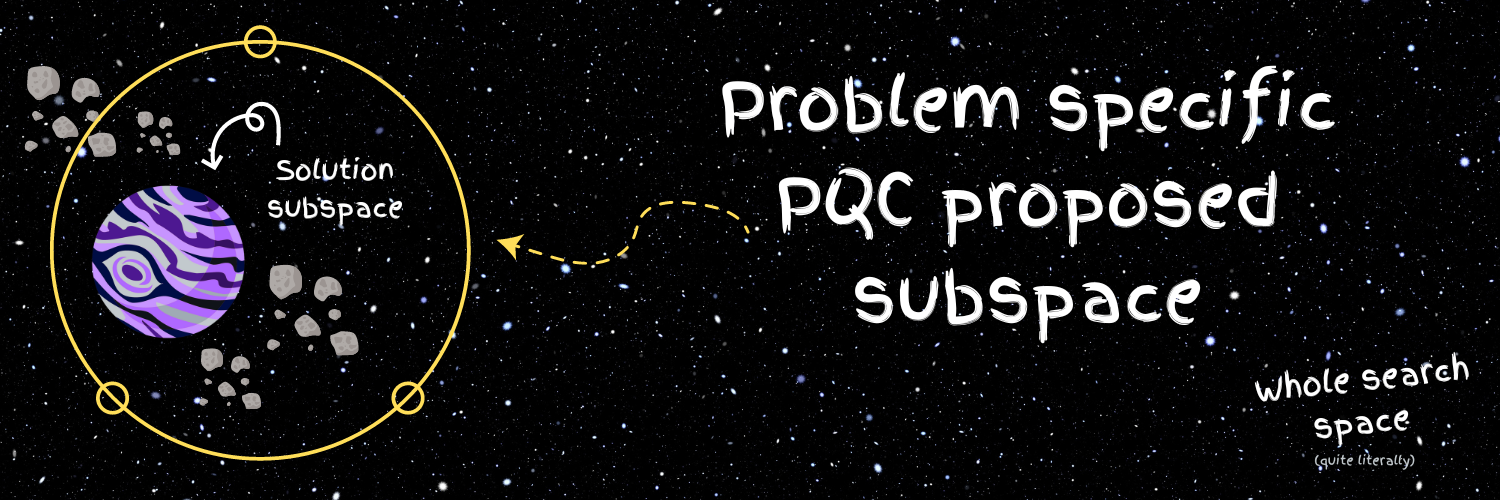

일반적으로 최적화 문제에는 둘 이상의 제약 조건이 존재합니다. 이러한 경우에, 각각의 제약 조건을 반영하는 여러 문제별 매개변수화된 하위 양자 회로를 생성합니다. 그런 다음 이러한 하위 회로를 적절하게 결합하면 최적화 문제에 둘 이상의 제약이 있더라도 **문제별 PQC를 생성하고 검색 공간을 줄이는 것** 이 여전히 가능합니다.

연습에서 사용할 논문은 각기 다른 특성과 제약 조건을 고려하여 문제에 접근하는 **서로 다른 4가지 유형의 PQC**를 제안합니다. NISQ 시대에서 게이트 수, 매개변수, 얽힘 및 회로 깊이와 같은 회로의 특성은 PQC를 설계할 때 고려해야 하는 중요한 요소이며 이곳에서는 위의 논문에서 설명한 몇 가지 접근 방식을 살펴보겠습니다. 우리는 **Estimator와 Sampler 프리미티브**를 사용하여 결과를 얻기 위해 루틴을 기반으로 VQE 알고리즘을 사용할 것입니다!

## PQCs satisfying only the constraints on the first line **[Eq. (1)](#eq1)**

TSP 문제에 대해 제안된 첫 번째 유형의 맞춤 PQC를 사용하여 우주 쓰레기를 효과적으로 수거해 보겠습니다. 이 논문은 아래와 같이 첫 번째 줄의 제약 조건만 고려할 것을 제안합니다:

\begin{equation}
\sum_{i}^{N} x_{i,p} = 1 ~~\forall p = 1...N.
\end{equation}
  
위에서 볼 수 있듯이, 각각의 제약조건에서, 정확히 한 변수는 1이 되어야 하고, 다른 변수는 0이 되어야 합니다. 이러한 유형의 제약 조건은 솔루션 집합을 **$W$ 상태에 해당하는 기저 집합**으로 제한합니다.

$W$ 상태는 큐비트 중 정확히 하나가 $|1\rangle$이고 다른 모든 큐비트는 진폭이 동일한 $|0\rangle$인 상태의 중첩입니다. $n$ 큐비트에 대한 $W$ 상태는 $|W\rangle = \frac{1}{\sqrt{2^n}} (|10...0\rangle + |01...0\rangle + |00...1\rangle)$ 으로 표시됩니다. 이 상태의 각 기저들은 위에서 언급한 제약 조건 ($\sum{x_i} = 1$)에 해당합니다. 다른 기저는 $\sum{x_i} = 1$의 제약 조건을 만족하지 않으므로 더이상 고려하지 않기 때문에 방정식의 제약 조건을 반영하여 문제를 해결하기 위한 부분 공간의 크기를 줄입니다. 첫 번째 줄. 각 기저의 진폭을 제어할 수 있는 방식으로  $W$ 상태를 나타내는 회로를 만들어 봅시다.

\begin{equation}
|W(φ)\rangle = \sum_{i} α_{i(φ)}|ψ_i\rangle \\
\sum_{i} {|α_{i(φ)}|}^2 = 1,   \\|ψ_i\rangle ∈ \{{|10...0\rangle, |01...0\rangle, |00...1\rangle}\}
\end{equation}

3큐비트 예제부터 도전해 봅시다. 아래의 3큐비트 회로에 대한 $W$ 상태를 구성해 보십시오!

<a id="exercise3"></a>
<div class="alert alert-block alert-success">
    
<b>연습 3:</b> 
    
<b>3-qubit W-State를 두개의 변수를 사용해 만들어 보세요.</b>

논문의 섹션 **section 3.2.1**를 참고하여 3큐비트 W 상태를 구현하는 방법을 탐색해 보십시오. 논문의 링크는 다음과 같습니다: **[Matsuo, A., Suzuki, Y., & Yamashita, S. (2020). Problem-specific parameterized quantum circuits of the VQE algorithm for optimization problems. arXiv preprint arXiv:2006.05643.](https://arxiv.org/pdf/2006.05643.pdf)**

구현해야 하는 회로는 다음과 같습니다.

![](images/week4_w_circuit.png)
</div> 

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector

# 회로를 초기화합니다.
circuit = QuantumCircuit(3)

# Parameter theta를 초기화합니다.
theta = ParameterVector('theta', 2)

#### enter your code below ####

#### enter your code above ####

circuit.draw("mpl")

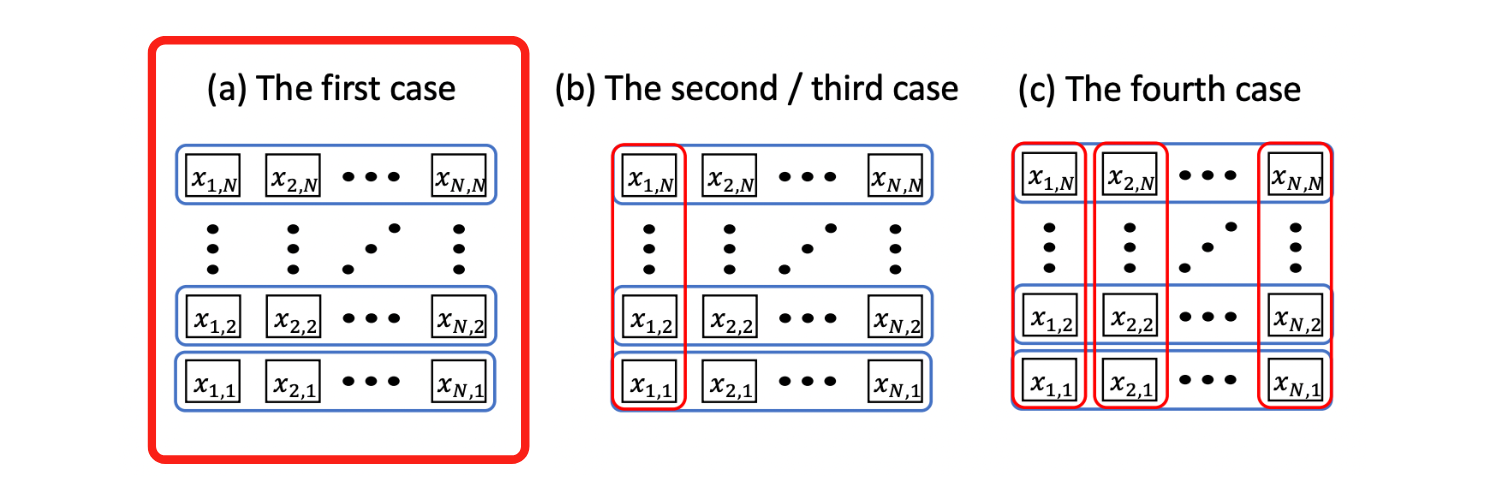

Image credits: [**Matsuo, A., Suzuki, Y., & Yamashita, S. (2020). Problem-specific parameterized quantum circuits of the VQE algorithm for optimization problems. arXiv preprint arXiv:2006.05643.**](https://arxiv.org/pdf/2006.05643.pdf)

이제 앞서 설명한 대로 루틴을 만들어볼 차례입니다. TSP 문제의 경우 문제는 $N$ 노드 그래프에 대해 인코딩되며 $N^2$ 큐비트로 인코딩됩니다. 문제의 제약 조건에 따라 PQC를 성공적으로 적용하려면 이 순서로 W 게이트 루틴을 추가해야 합니다. 먼저 2노드 그래프의 경우를 살펴본 다음, **임의의 N 값에 대해 W 상태를 생성하는 일반화 함수**에 대해 작업해 보겠습니다.

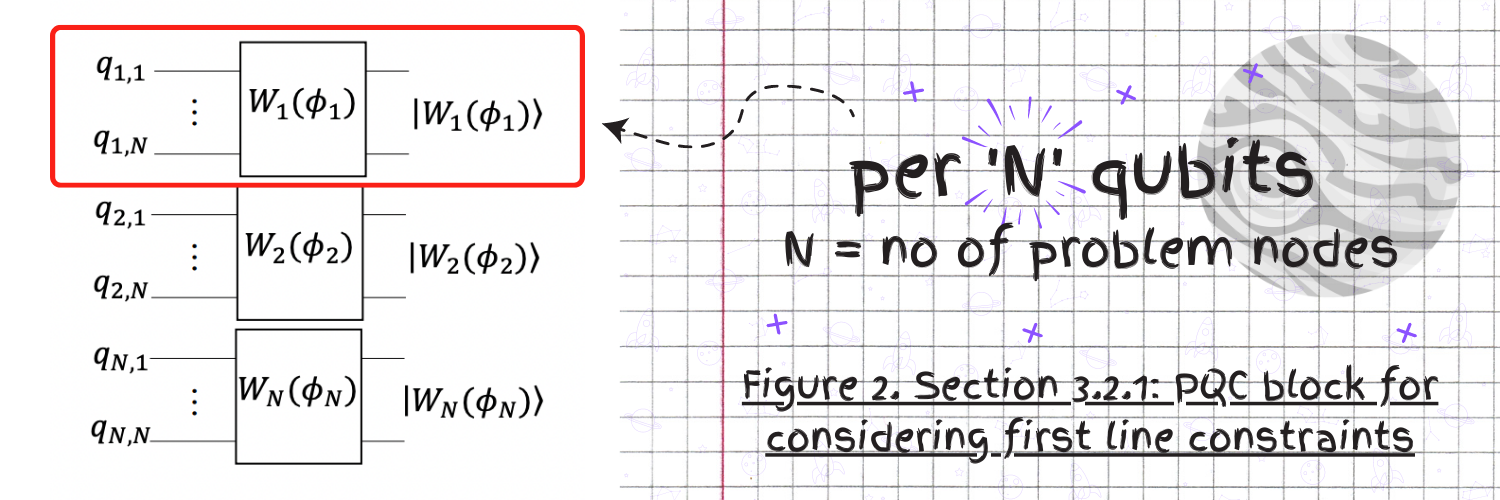

이곳의 예제에서, 2노드 그래프에 대한 이 조건을 구상해 봅시다. 2노드 그래프의 경우 4큐비트가 필요합니다. **여기서 우리는 row-major 정렬 방식을 사용할 것입니다.** 처음 두 큐비트는 그림과 같이 각각 첫 번째 행의 열을 나타내고 마지막 2개 큐비트는 $N^{th}$ 행의 열을 나타내며, 이 경우 두 번째 행의 두 요소가 됩니다. 일반적으로 필요한 매개변수의 수는 $(N)*(N-1)$ 입니다. 2노드 그래프에 이 TSP 얽힘 루틴을 적용하는 방법을 확인하고 연습에서 일반 솔루션에 대해 이를 사용해 보겠습니다.

In [ ]:
# 노드 개수가 2개인 경우의 예시입니다.
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

# 노드 개수 N = 2 입니다.
N = 2

# 회로와 parameter를 설정합니다.
circuit = QuantumCircuit(N**2)
theta =  ParameterVector('theta', length=(N-1)*N)

# Block 1 ----------------
# X Gate -----------------
circuit.x(0)
# Parameter Gates --------
circuit.ry(theta[0],1)
circuit.cz(0,1)
circuit.ry(-theta[0],1)
# CX gates ---------------
circuit.cx(1,0)

# Block 2 ----------------
# X Gate -----------------
circuit.x(2)
# Parameter Gates --------
circuit.ry(theta[1],3)
circuit.cz(2,3)
circuit.ry(-theta[1],3)
# CX gates ---------------
circuit.cx(3,2)

circuit.draw("mpl")

$N=3$ 인 그래프의 경우에도 마찬가지입니다. 연습 3에서 만든 회로는 블록으로 3번 적용되는 회로입니다. 일반적으로 문제를 풀기 위해서는, N 큐비트에 W 상태가 적용된 걸 하나의 블록이라 했을 때, $N^2$ 큐비트에 걸쳐 총 N개의 블록이 적용되어야 합니다.

다음 연습에서는 **일반적인 N 큐비트 경우**에 대해 위에 표시된 제약 조건에 대해 **TSP 얽힘 루틴**을 구성해 봅시다. 이 연습을 완료하기 위해 그레이더에 함수를 전달합니다.

<a id="exercise5"></a>
<div class="alert alert-block alert-success">
    
<b>연습 5:</b> 

<b>일반적인 N 큐비트 경우에 대해 논문에 설명된 대로 TSP 얽힘 루틴을 구성합니다</b>. 그래프의 노드 수 만큼의 **N개의 입력**을 받아들이고 앞에서 설명한 대로 얽힘 루틴을 사용하여 **QuantumCircuit**를 반환하는 함수를 빈 부분을 채워 완성합니다. **이 함수를 그레이더에 전달하여 연습을 마무리 합니다.**
    
이 함수를 사용하여 VQE 루틴을 실행하고 다음 연습에서 앞서 만들어 둔 그래프의 솔루션을 계산해봅시다! </div> 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

def tsp_entangler(N):
    
    # 회로와 parameter를 설정합니다.
    circuit = QuantumCircuit(N**2)
    theta =  ParameterVector('theta', length=(N-1)*N)
    
    ############# 
    # Hint: One of the approaches that you can go for is having an outer `for` loop for each node and 2 inner loops for each block. /
    # Continue on by applying the same routine as we did above for each node with inner `for` loops for /
    # the ry-cz-ry routine and cx gates. Selecting which indices to apply for the routine will be the /
    # key thing to solve here. The indices will depend on which parameter index you are checking for and the current node! /
    # Reference solution has one outer loop for nodes and one inner loop each for rz-cz-ry and cx gates respectively.
    ############# 
    
    #### enter your code below ####
    for i in range(N):
        # X Gate
        circuit.x(N*i)
        # Parameter Gates
        for j in range(N-1):
            circuit.ry(theta[(N-1)*i+j], N*i+j+1)
            circuit.cz(N*i+j, N*i+j+1)
            circuit.ry(-theta[(N-1)*i+j], N*i+j+1)
        # CX gates
        for j in range(N-1):
            circuit.cx(N*i+j+1, N*i+j)
    #### enter your code above ####

    return circuit

수고하셨습니다! 이제 PQC를 실행하고 솔루션을 테스트하기 위한 코드 블록이 생겼습니다! 문제의 최상의 결과를 계산하기 위한 VQE 함수 구성을 시작하겠습니다.

### Solving the problem using VQE algorithm

<a id="exercise6"></a>
<div class="alert alert-block alert-success">
    
<b>연습 6:</b> 
    
<b>연습 5에서 만든 TSP 얽힘에 대한 VQE 루틴을 작성해봅시다.</b> 주석을 참고하여 아래 코드 블록을 완성해보세요. **얻은 결과를 그레이더에 전달하여 연습을 완료합니다.** 성공하기위해서 시드 값을 변경하지 마세요.

    
이어서 이 루틴을 사용하여 일반적인 경우에 대한 VQE 함수를 구성하고 논문에 설명된 대로 다음 PQC를 만들어 봅시다!  </div> 

In [ ]:
# 정의한 함수를 사용해 ansatz를 설정합니다.
ansatz = tsp_entangler(3)

In [ ]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]  # Estimator를 이용해 cost function을 계산합니다.
    return cost

#### Running the routine and checking our result for the first PQC for 3 qubit case:

In [ ]:
# SciPy 최소화 함수를 불러옵니다.
from scipy.optimize import minimize

# 중간 계산 결과를 저장하는 dictionary 입니다.
history = {"parameters": [], "mean": []}

# callback 함수를 정의합니다.
def store_intermediate_result(intermediate_result):
    history["parameters"].append(intermediate_result.x)
    history["mean"].append(intermediate_result.fun)

# parameter의 초기값을 설정합니다.
np.random.seed(10)
x0 = np.random.rand((n-1)*n) * 2 * np.pi

# 최적화를 수행합니다.
result = minimize(cost_func_vqe, x0, args=(ansatz, qubitOp, estimator), method="L-BFGS-B", callback=store_intermediate_result)

print(result)

## Computing the Eigenstate from the VQEResult object

이제 다음으로, **솔루션의 고유 상태를 계산하고** `result` 개체에서 **최상의 분포에 해당하는 이진 문자열**을 가져옵시다. 고유 상태를 얻기 위해 앞에서 설정한 `ansatz` 회로를 가져옵니다. `result` 개체에서 `x`로 설정된 parameter를 가져와 `Sampler`에 입력합니다. 우리가 얻은 `nearest_probability_distribution`의 최대값에 해당하는 이진 값은 평가를 위해 전달할 최상의 솔루션의 이진수 표현입니다!

이제 `Sampler` 루틴을 설정해 보겠습니다. 먼저  `Sampler` 루틴을 적용하기 위해 `ansatz`에 측정을 가합니다. 여기서 `inplace=False`로 설정하여 측정이 추가된 회로를 새 회로로 저장합니다.

In [ ]:
measure_ansatz = ansatz.measure_all(inplace=False)  # 구해진 eigenstate를 확인하기 위해 measurement를 추가합니다.
measure_ansatz.draw("mpl")

### Setting up Sampler to obtain our best bitstring

이어서, 방금 계산한 결과에서 최적의 값에 대한 비트열을 추출하기 위해 샘플러를 설정해 봅시다. 위에서 계산된 최적의 회로의 측정값을 전달하고 결과에서 parameter 값 x를 추출합니다.

이제 이것들을 사용하여 고유 상태를 얻고 이 분포에서 최적의 결과를 얻어 봅시다!

<a id="exercise7"></a>
<div class="alert alert-block alert-success">
    
<b>연습 7:</b> 
    
Sampler 루틴을 만들고 최적의 회로와 이전에 계산한 VQE 결과에서 얻은 매개변수 값 목록을 전달합니다. 막 얻은 샘플러 결과와 가장 근접한 확률 분포를 얻습니다. **성공적인 채점을 위해 시드 값을 변경하지 마십시오.**
    
이 값을 사용하여 다음 셀에서 솔루션의 가능성을 계산합니다.

In [ ]:
def BestBitstring(result, measure_ansatz, sampler):
    energy = result.fun

    sampler_result = sampler.run(measure_ansatz.assign_parameters(result.x)).result()
    result_prob_dist = sampler_result.quasi_dists[0]

    max_key = format(max(result_prob_dist, key = result_prob_dist.get),"016b")

    result_bitstring = np.array(list(map(int, max_key)))

    return energy, sampler_result, result_prob_dist, result_bitstring

In [ ]:
from qiskit.primitives import Sampler

# 결과를 확인합니다.
sampler = Sampler()
energy, sampler_result, result_prob_dist, result_bitstring = BestBitstring(result=result, measure_ansatz=measure_ansatz, sampler=sampler)
print("Optimal bitstring = ", result_bitstring[7:])

In [ ]:
# 얻어진 결과의 cost function 값을 계산하고 결과를 그림으로 표시합니다.
TSPCost(energy = energy, result_bitstring = result_bitstring[7:], adj_matrix = adj_matrix)

In [ ]:
# 최적화 플랏을 그립니다.
PlotGraph(ideal = energy_numpy, mean = [history["mean"]])